### EDA and Linear Regression

In [1]:
import pandas as pd
import numpy as np
import re
import math
import seaborn as sns
from matplotlib import pyplot as plt
from collections import defaultdict
#from IPython.core.display import display, HTML
import pickle
import copy
#from sklearn.preprocessing import OneHotEncoder
#from sklearn.model_selection import train_test_split
#display(HTML(my_html))     # make sure Jupyter knows to display it as HTML

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import  StandardScaler, PolynomialFeatures, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score

In [2]:
pd.options.display.float_format = "{:,.5f}".format

In [3]:
director='herzog'
dir_str = director + '/'

films_filename = 'films_to_analyze_' + director
with open(dir_str + films_filename, 'rb') as read_file:
    films_to_analyze = pickle.load(read_file)

In [4]:
films_to_analyze.head()

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Samuel S. Bowser,David R. Pacheco Jr.,Regina Eisert,Olav T. Oftedal,Kevin Emery,Ryan Andrew Evans,Doug MacAyeal,Stefan Pashov,Scott Rowland,Reinhard Lichtenberg
1,Fireball: Visitors from Darker Worlds,"2,020.00000",13 November 2020 (Australia),97.00000,97.00000,NaN,NaN,NaN,NaN,7.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,"Family Romance, LLC","2,019.00000",3 July 2020 (USA),89.00000,89.00000,NaN,"3,126.00000","3,126.00000",NaN,6.70000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,Nomad: In the Footsteps of Bruce Chatwin,"2,019.00000",26 August 2020 (USA),85.00000,85.00000,NaN,"78,100.00000","78,100.00000",NaN,6.90000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,Meeting Gorbachev,"2,018.00000",3 May 2019 (USA),90.00000,90.00000,NaN,"327,912.00000","319,230.00000","327,912.00000",7.20000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,Into the Inferno,"2,016.00000",28 October 2016 (USA),104.00000,104.00000,NaN,"4,861.00000","3,679.00000","4,861.00000",7.20000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [5]:
prevalent_actors_filename  = 'prevalent_actors_' + director
with open(dir_str + prevalent_actors_filename, 'rb') as read_file:
    prevalent_actor_columns = pickle.load(read_file)

In [6]:
prevalent_actor_columns

Index(['Werner Herzog', 'Klaus Kinski', 'Volker Prechtel', 'Brad Dourif',
       'Peter Berling', 'Clemens Scheitz', 'Michael Shannon', 'Eva Mattes'],
      dtype='object')

In [7]:
pickled_dict_of_actors_filename = 'dict_of_actors_' + director +'.pickle'
with open(dir_str + pickled_dict_of_actors_filename, 'rb') as read_file:
    dict_of_all_actors  = pickle.load(read_file) 

In [8]:
analysis_columns = ['title', 'year', 'duration', 'cinematographer', 'documentary', 'tv_series','rating', 'rating_count', *prevalent_actor_columns]

In [9]:
analysis_columns

['title',
 'year',
 'duration',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating',
 'rating_count',
 'Werner Herzog',
 'Klaus Kinski',
 'Volker Prechtel',
 'Brad Dourif',
 'Peter Berling',
 'Clemens Scheitz',
 'Michael Shannon',
 'Eva Mattes']

## Dataset partitioned for analysis
except one-hot-encoding `cinematographer`

In [10]:
films_to_analyze.head()

,title,year,release_date,duration,runtime,budget,worldwide_gross,worldwide_gross_imdb,worldwide_gross_bo,rating,...,Samuel S. Bowser,David R. Pacheco Jr.,Regina Eisert,Olav T. Oftedal,Kevin Emery,Ryan Andrew Evans,Doug MacAyeal,Stefan Pashov,Scott Rowland,Reinhard Lichtenberg
1,Fireball: Visitors from Darker Worlds,"2,020.00000",13 November 2020 (Australia),97.00000,97.00000,NaN,NaN,NaN,NaN,7.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,"Family Romance, LLC","2,019.00000",3 July 2020 (USA),89.00000,89.00000,NaN,"3,126.00000","3,126.00000",NaN,6.70000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,Nomad: In the Footsteps of Bruce Chatwin,"2,019.00000",26 August 2020 (USA),85.00000,85.00000,NaN,"78,100.00000","78,100.00000",NaN,6.90000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,Meeting Gorbachev,"2,018.00000",3 May 2019 (USA),90.00000,90.00000,NaN,"327,912.00000","319,230.00000","327,912.00000",7.20000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,Into the Inferno,"2,016.00000",28 October 2016 (USA),104.00000,104.00000,NaN,"4,861.00000","3,679.00000","4,861.00000",7.20000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [11]:
films_and_features_to_analyze_df = films_to_analyze[analysis_columns]

In [12]:
films_and_features_to_analyze_df.head() 

,title,year,duration,cinematographer,documentary,tv_series,rating,rating_count,Werner Herzog,Klaus Kinski,Volker Prechtel,Brad Dourif,Peter Berling,Clemens Scheitz,Michael Shannon,Eva Mattes
1,Fireball: Visitors from Darker Worlds,"2,020.00000",97.00000,Peter Zeitlinger,1.00000,0.00000,7.00000,"1,439.00000",1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
2,"Family Romance, LLC","2,019.00000",89.00000,Werner Herzog,0.00000,0.00000,6.70000,"1,913.00000",0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,Nomad: In the Footsteps of Bruce Chatwin,"2,019.00000",85.00000,Louis Caulfield,1.00000,0.00000,6.90000,551.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,Meeting Gorbachev,"2,018.00000",90.00000,Yuri Burak,1.00000,0.00000,7.20000,"1,694.00000",1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,Into the Inferno,"2,016.00000",104.00000,Peter Zeitlinger,1.00000,0.00000,7.20000,"7,392.00000",1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [13]:
cinematographer_include_threshold = films_and_features_to_analyze_df['cinematographer'].value_counts().min()
cinematographer_include_threshold

1

In [14]:
value_counts = films_and_features_to_analyze_df['cinematographer'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= cinematographer_include_threshold].index
films_and_features_to_analyze_df['cinematographer'].replace(to_remove, 'OTHER', inplace=True)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/pandas/core/series.py:4479: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


### Regression analysis on `rating`,  `duration`, and `year` etc

#### `rating` as target

### Selecting columns for Train Test Split

In [15]:
films_and_features_to_analyze_df.columns # review columns we start with

Index(['title', 'year', 'duration', 'cinematographer', 'documentary',
       'tv_series', 'rating', 'rating_count', 'Werner Herzog', 'Klaus Kinski',
       'Volker Prechtel', 'Brad Dourif', 'Peter Berling', 'Clemens Scheitz',
       'Michael Shannon', 'Eva Mattes'],
      dtype='object')

In [16]:
selected_cols = [*films_and_features_to_analyze_df.columns[1:6], *films_and_features_to_analyze_df.columns[7:]]

In [17]:
selected_cols

['year',
 'duration',
 'cinematographer',
 'documentary',
 'tv_series',
 'rating_count',
 'Werner Herzog',
 'Klaus Kinski',
 'Volker Prechtel',
 'Brad Dourif',
 'Peter Berling',
 'Clemens Scheitz',
 'Michael Shannon',
 'Eva Mattes']

In [18]:
X= films_and_features_to_analyze_df[selected_cols]
y= films_and_features_to_analyze_df['rating']

In [19]:
y.isnull().values.any()

False

### Train-val vs. test split

In [20]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [21]:
X_test

,year,duration,cinematographer,documentary,tv_series,rating_count,Werner Herzog,Klaus Kinski,Volker Prechtel,Brad Dourif,Peter Berling,Clemens Scheitz,Michael Shannon,Eva Mattes
1,"2,020.00000",97.00000,Peter Zeitlinger,1.00000,0.00000,"1,439.00000",1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
6,"2,016.00000",98.00000,Peter Zeitlinger,0.00000,0.00000,"2,458.00000",0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
40,"1,990.00000",91.00000,OTHER,1.00000,0.00000,566.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
51,"1,981.00000",44.00000,Thomas Mauch,1.00000,1.00000,732.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
14,"2,010.00000",90.00000,OTHER,1.00000,0.00000,"7,766.00000",1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
62,"1,971.00000",42.00000,Jörg Schmidt-Reitwein,1.00000,1.00000,393.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
36,"1,992.00000",54.00000,OTHER,1.00000,0.00000,"5,376.00000",1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
55,"1,977.00000",115.00000,Thomas Mauch,0.00000,0.00000,"13,072.00000",0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000
13,"2,011.00000",39.00000,Werner Herzog,1.00000,0.00000,127.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
65,"1,970.00000",96.00000,Thomas Mauch,0.00000,0.00000,"5,446.00000",0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


## Preprocessing

### Categorical Variable Preprocessing

#### One-hot-encoding

In [22]:
cat_ohe_vars = ['cinematographer']
X_train_val_cat_ohe = X_train_val[cat_ohe_vars]
#X_train_cat_ohe 

In [23]:
ohe = OneHotEncoder(sparse=False,  handle_unknown='ignore')
ohe.fit(X_train_val_cat_ohe)
cat_ohe = ohe.transform(X_train_val_cat_ohe)

In [24]:
columns=ohe.get_feature_names(cat_ohe_vars)
columns

array(['cinematographer_Henning Brümmer',
       'cinematographer_Jörg Schmidt-Reitwein', 'cinematographer_OTHER',
       'cinematographer_Peter Zeitlinger',
       'cinematographer_Rainer Klausmann', 'cinematographer_Thomas Mauch',
       'cinematographer_Werner Herzog'], dtype=object)

In [25]:
X_train_val_cat_ohe_df = pd.DataFrame(cat_ohe, columns=columns, index=X_train_val_cat_ohe.index)
X_train_val_cat_ohe_df.head()

,cinematographer_Henning Brümmer,cinematographer_Jörg Schmidt-Reitwein,cinematographer_OTHER,cinematographer_Peter Zeitlinger,cinematographer_Rainer Klausmann,cinematographer_Thomas Mauch,cinematographer_Werner Herzog
34,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
4,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000
60,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000
19,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000
9,0.00000,0.00000,0.00000,1.00000,0.00000,0.00000,0.00000


Repeating transformations on testing set

In [26]:
X_test_cat_ohe = X_test[['cinematographer']]
X_test_cat_ohe
cat_ohe_test = ohe.transform(X_test_cat_ohe)

cat_ohe_columns = ohe.get_feature_names(['cinematographer'])
X_test_cat_ohe_df = pd.DataFrame(cat_ohe_test, columns=cat_ohe_columns)


### Continuous Variable Preprocessing

In [27]:
cont_column_names = ['year', 'duration', 'rating_count']
X_train_val_cont = X_train_val[cont_column_names ]

X_test_cont      = X_test[     cont_column_names ]


X_train_val_cont.head()


,year,duration,rating_count
34,"1,995.00000",59.00000,679.00000
4,"2,018.00000",90.00000,"1,694.00000"
60,"1,974.00000",45.00000,"2,304.00000"
19,"2,007.00000",99.00000,"17,182.00000"
9,"2,012.00000",49.00000,"1,090.00000"


#### Generate log and polynomials

In [28]:
#X_train_val_cont_poly.head()

In [29]:
X_train_val_cont['log_year']         = np.log(X_train_val_cont.year)
X_train_val_cont['log_rating_count'] = np.log(X_train_val_cont.rating_count)


X_test_cont['log_year']         = np.log(X_test_cont.year)
X_test_cont['log_rating_count'] = np.log(X_test_cont.rating_count)

<ipython-input-29-d30627963e3a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_val_cont['log_year']         = np.log(X_train_val_cont.year)
<ipython-input-29-d30627963e3a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_val_cont['log_rating_count'] = np.log(X_train_val_cont.rating_count)
<ipython-input-29-d30627963e3a>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [30]:
X_test_cont.shape[0]

12

#### Concatenate columns

In [31]:
cat_columns = ['documentary', 'tv_series', *prevalent_actor_columns]
X_train_val_cat_df = X_train_val[cat_columns]
#X_train_val_cat_df

X_test_cat_df = X_test[cat_columns]
#X_train_val_cat_df

In [32]:
X_test_cat_df.isnull().values.any()

False

In [46]:
X_train_val_combo= pd.concat([X_train_val_cont, X_train_val_cat_ohe_df, X_train_val_cat_df, ], axis='columns')
X_test_combo = pd.concat([X_test_cont.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True), ], axis='columns')

In [47]:
X_test_cat_df.shape

(12, 10)

In [48]:
X_train_val_combo.isnull().values.any()

False

In [49]:
X_test_combo.isnull().values.any()

False

In [50]:
X_test_combo

,year,duration,rating_count,log_year,log_rating_count,cinematographer_Henning Brümmer,cinematographer_Jörg Schmidt-Reitwein,cinematographer_OTHER,cinematographer_Peter Zeitlinger,cinematographer_Rainer Klausmann,...,documentary,tv_series,Werner Herzog,Klaus Kinski,Volker Prechtel,Brad Dourif,Peter Berling,Clemens Scheitz,Michael Shannon,Eva Mattes
0,"2,020.00000",97.00000,"1,439.00000",7.61085,7.27170,0.00000,0.00000,0.00000,1.00000,0.00000,...,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
1,"2,016.00000",98.00000,"2,458.00000",7.60887,7.80710,0.00000,0.00000,0.00000,1.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000
2,"1,990.00000",91.00000,566.00000,7.59589,6.33859,0.00000,0.00000,1.00000,0.00000,0.00000,...,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
3,"1,981.00000",44.00000,732.00000,7.59136,6.59578,0.00000,0.00000,0.00000,0.00000,0.00000,...,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
4,"2,010.00000",90.00000,"7,766.00000",7.60589,8.95751,0.00000,0.00000,1.00000,0.00000,0.00000,...,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
5,"1,971.00000",42.00000,393.00000,7.58630,5.97381,0.00000,1.00000,0.00000,0.00000,0.00000,...,1.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
6,"1,992.00000",54.00000,"5,376.00000",7.59689,8.58970,0.00000,0.00000,1.00000,0.00000,0.00000,...,1.00000,0.00000,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
7,"1,977.00000",115.00000,"13,072.00000",7.58934,9.47823,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,1.00000,0.00000,1.00000
8,"2,011.00000",39.00000,127.00000,7.60639,4.84419,0.00000,0.00000,0.00000,0.00000,0.00000,...,1.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000
9,"1,970.00000",96.00000,"5,446.00000",7.58579,8.60264,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000


In [51]:
selected_columns = X_train_val_combo.columns
X_train_val_combo.columns

Index(['year', 'duration', 'rating_count', 'log_year', 'log_rating_count',
       'cinematographer_Henning Brümmer',
       'cinematographer_Jörg Schmidt-Reitwein', 'cinematographer_OTHER',
       'cinematographer_Peter Zeitlinger', 'cinematographer_Rainer Klausmann',
       'cinematographer_Thomas Mauch', 'cinematographer_Werner Herzog',
       'documentary', 'tv_series', 'Werner Herzog', 'Klaus Kinski',
       'Volker Prechtel', 'Brad Dourif', 'Peter Berling', 'Clemens Scheitz',
       'Michael Shannon', 'Eva Mattes'],
      dtype='object')

### Train vs. val split

In [52]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val_combo, y_train_val, test_size=.25, random_state=43)

### Manually tune regularization with both Lasso and Ridge

In [53]:
#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true)) 

#mae(y_test, test_set_pred)

### Lasso CV

In [54]:
X_train_val_combo.values

array([[1.9950e+03, 5.9000e+01, 6.7900e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [2.0180e+03, 9.0000e+01, 1.6940e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.9740e+03, 4.5000e+01, 2.3040e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [1.9980e+03, 4.5000e+01, 1.1000e+01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.9740e+03, 1.1000e+02, 1.6417e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.9890e+03, 5.2000e+01, 6.6500e+02, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

### Polynomial testing

In [57]:
poly = PolynomialFeatures(degree=2)
X_train_val_combo =  poly.fit_transform(X_train_val_combo)
X_test_combo = poly.transform(X_test_combo)
## Scale the data as before
std = StandardScaler()
std.fit(X_train_val_combo)
## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train_val_combo)
X_te = std.transform(X_test_combo)

### End of Polynomial testing

In [43]:
## Scale the data as before
std = StandardScaler()
std.fit(X_train_val_combo.values)

AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train_val_combo.values)
X_te = std.transform(X_test_combo.values)

In [58]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train_val)

/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0011131813260720769, tolerance: 0.0010922105263157893
  model = cd_fast.enet_coordinate_descent(


LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [59]:
# This is the best alpha value it found 
lasso_model.alpha_

0.03331294787934674

In [68]:
len(lasso_model.coef_)

38503

In [60]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_train.columns, lasso_model.coef_))
coefficients

[('year', 0.0),
 ('duration', 0.0),
 ('rating_count', -0.0),
 ('log_year', -0.0),
 ('log_rating_count', 0.010357839292816553),
 ('cinematographer_Henning Brümmer', -0.0),
 ('cinematographer_Jörg Schmidt-Reitwein', 0.0),
 ('cinematographer_OTHER', 0.0),
 ('cinematographer_Peter Zeitlinger', 0.0),
 ('cinematographer_Rainer Klausmann', -0.0),
 ('cinematographer_Thomas Mauch', 0.0),
 ('cinematographer_Werner Herzog', -0.0),
 ('documentary', 0.0),
 ('tv_series', -0.0),
 ('Werner Herzog', 0.0),
 ('Klaus Kinski', -0.0),
 ('Volker Prechtel', 0.0),
 ('Brad Dourif', 0.0),
 ('Peter Berling', -0.0),
 ('Clemens Scheitz', -0.030407767915934754),
 ('Michael Shannon', 0.0),
 ('Eva Mattes', -0.0)]

In [61]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

In [62]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

0.49898070904893

In [63]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 

0.31061005798925645

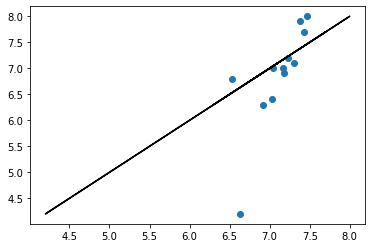

In [64]:
plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')

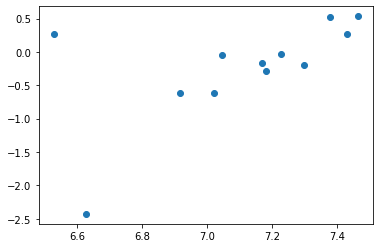

In [65]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)

In [66]:
coefficients_df  = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient'])

coefficients_df['abs_val_of_coefficient'] = coefficients_df.Coefficient.abs()
coefficients_df.sort_values(by='abs_val_of_coefficient', ascending=False, inplace=True)

coefficients_df.drop(columns='abs_val_of_coefficient', inplace=True)
coefficients_df

,Feature,Coefficient
19,Clemens Scheitz,-0.03041
4,log_rating_count,0.01036
0,year,0.00000
12,documentary,0.00000
20,Michael Shannon,0.00000
18,Peter Berling,-0.00000
17,Brad Dourif,0.00000
16,Volker Prechtel,0.00000
15,Klaus Kinski,-0.00000
14,Werner Herzog,0.00000


In [67]:
Lasso_CV_model_w_rc = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Lasso_CV_model_w_rc 

{'r2_score': <function sklearn.metrics._regression.r2_score(y_true, y_pred, *, sample_weight=None, multioutput='uniform_average')>,
 'mean absolute error': 0.49898070904893,
 'coefficients':                                   Feature  Coefficient
 19                        Clemens Scheitz     -0.03041
 4                        log_rating_count      0.01036
 0                                    year      0.00000
 12                            documentary      0.00000
 20                        Michael Shannon      0.00000
 18                          Peter Berling     -0.00000
 17                            Brad Dourif      0.00000
 16                        Volker Prechtel      0.00000
 15                           Klaus Kinski     -0.00000
 14                          Werner Herzog      0.00000
 13                              tv_series     -0.00000
 11          cinematographer_Werner Herzog     -0.00000
 1                                duration      0.00000
 10           cinematograp

In [ ]:
LCVM_w_rc_filename = 'Lasso_CV_model_w_rc_' + director
with open(dir_str + LCVM_w_rc_filename, 'wb') as to_write:
    pickle.dump(Lasso_CV_model_w_rc, to_write)

### Rerun the model without using rating count

In [ ]:
X_tr = pd.DataFrame(X_tr, columns=X_train.columns )
X_tr.head()

In [ ]:
X_te = pd.DataFrame(X_te, columns=X_train.columns )

In [ ]:
X_tr_no_rc  = X_tr.drop(columns = ['rating_count', 'log_rating_count'])

In [ ]:
X_te_no_rc = X_te.drop(columns = ['rating_count', 'log_rating_count'])

In [ ]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr_no_rc, y_train_val)

# This is the best alpha value it found 
lasso_model.alpha_

In [ ]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_tr_no_rc.columns, lasso_model.coef_))
coefficients_df = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient']).sort_values(by='Coefficient', ascending=False).head(10)

In [ ]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te_no_rc)

In [ ]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

In [ ]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 


In [ ]:
plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')
#plt.plot( x_te_no_rc, y_test, c='k')

In [ ]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)



In [ ]:
coefficients_df.head()

In [ ]:
Lasso_CV_model_no_rc = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Lasso_CV_model_no_rc 


In [ ]:
LCVM_no_rc_filename = 'Lasso_CV_model_no_rc_' + director
with open(dir_str + LCVM_no_rc_filename, 'wb') as to_write:
    pickle.dump(Lasso_CV_model_no_rc, to_write)

In [ ]:
from sklearn.linear_model import lars_path
print("Computing regularization path using the LARS ...")
alphas, _, coefs = lars_path(np.array(X_tr_no_rc), y_train_val.values, method='lasso')

In [ ]:
xx = np.sum(np.abs(coefs.T), axis=1)
xx /= xx[-1]

plt.figure(figsize=(10,10))
plt.plot(xx, coefs.T)
ymin, ymax = plt.ylim()
plt.vlines(xx, ymin, ymax, linestyle='dashed')
plt.xlabel('|coef| / max|coef|')
plt.ylabel('Coefficients')
plt.title('LASSO Path')
plt.axis('tight')
plt.legend(X_tr_no_rc.columns)
plt.show()

### Ridge regression

In [ ]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_tr_no_rc, y_train_val)

# This is the best alpha value it found 
ridge_model.alpha_

In [ ]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_tr_no_rc.columns, ridge_model.coef_))

coefficients_df  = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient'])

coefficients_df['abs_val_of_coefficient'] = coefficients_df.Coefficient.abs()
coefficients_df.sort_values(by='abs_val_of_coefficient', ascending=False, inplace=True)

coefficients_df.drop(columns='abs_val_of_coefficient', inplace=True)
coefficients_df

In [ ]:
# Make predictions on the test set using the new model
test_set_pred = ridge_model.predict(X_te_no_rc)

In [ ]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

In [ ]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 


In [ ]:
plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')

In [ ]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)


In [ ]:
coefficients_df.head()

In [ ]:
Ridge_CV_model_no_rc = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Ridge_CV_model_no_rc 


In [ ]:
RCVM_no_rc_filename = 'Ridge_CV_model_no_rc' + director
with open(dir_str + RCVM_no_rc_filename, 'wb') as to_write:
    pickle.dump(Ridge_CV_model_no_rc, to_write)

## Re-analyzed including `budget` as a feature 
This entails a fewer rows of data, since many of the films don't have budget info available on IMDB

In [ ]:
films_to_analyze_financial_df = films_to_analyze[(films_to_analyze['budget'] > 0) & (films_to_analyze['worldwide_gross'] > 0)]

In [ ]:
analysis_columns = ['title', 'year', 'duration', 'budget', 'cinematographer', 'documentary', 'tv_series','rating', *prevalent_actor_columns]

In [ ]:
analysis_columns 

In [ ]:
films_and_features_to_analyze_df = films_to_analyze_financial_df[analysis_columns]

In [ ]:
cinematographer_include_threshold = films_and_features_to_analyze_df['cinematographer'].value_counts().min()
cinematographer_include_threshold

In [ ]:
value_counts = films_and_features_to_analyze_df['cinematographer'].value_counts() # Specific column 
to_remove = value_counts[value_counts <= cinematographer_include_threshold].index
films_and_features_to_analyze_df['cinematographer'].replace(to_remove, 'OTHER', inplace=True)

### Regression analysis on `rating`,  `duration`, `year` and `budget` etc

In [ ]:
films_and_features_to_analyze_df.columns

In [ ]:
selected_cols = [*films_and_features_to_analyze_df.columns[1:7], *films_and_features_to_analyze_df.columns[8:]]

In [ ]:
X= films_and_features_to_analyze_df[selected_cols]
y= films_and_features_to_analyze_df['rating']

In [ ]:
X

In [ ]:
y.isnull().values.any()

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [ ]:
# X_train_val

## Preprocessing


### Categorical Variable Preprocessing

#### One-hot-encoding

In [ ]:
cat_ohe_vars = ['cinematographer']
X_train_val_cat_ohe = X_train_val[cat_ohe_vars]
#X_train_cat_ohe 

In [ ]:
ohe = OneHotEncoder(sparse=False,  handle_unknown='ignore')
ohe.fit(X_train_val_cat_ohe)
cat_ohe = ohe.transform(X_train_val_cat_ohe)

In [ ]:
columns=ohe.get_feature_names(cat_ohe_vars)
columns

In [ ]:
cat_ohe.shape[0]

In [ ]:
X_train_val_cat_ohe.shape[0]

In [ ]:
X_train_val_cat_ohe_df = pd.DataFrame(cat_ohe, columns=columns, index=X_train_val_cat_ohe.index)
X_train_val_cat_ohe_df.head()

In [ ]:
X_test_cat_ohe = X_test[['cinematographer']]
X_test_cat_ohe
cat_ohe_test = ohe.transform(X_test_cat_ohe)

cat_ohe_columns = ohe.get_feature_names(['cinematographer'])
X_test_cat_ohe_df = pd.DataFrame(cat_ohe_test, columns=cat_ohe_columns)


### Continuous Variable Preprocessing

In [ ]:
cont_column_names = ['year', 'duration', 'budget']
X_train_val_cont = X_train_val[cont_column_names ]

X_test_cont      = X_test[     cont_column_names ]


X_train_val_cont.head()

In [ ]:
X_train_val_cont['log_year']         = np.log(X_train_val_cont.year)
X_train_val_cont['log_budget']         = np.log(X_train_val_cont.budget)
X_train_val_cont['budget_sq'] = X_train_val_cont.budget**2
#X_train_val_cont['budget_per_year'] = X_train_val_cont.budget/X_train_val_cont.year


X_test_cont['log_year']         = np.log(X_test_cont.year)
X_test_cont['log_budget']         = np.log(X_test_cont.budget)
X_test_cont['budget_sq']  =  X_test_cont.budget**2
#X_test_cont['budget_per_year']  =   X_test_cont.budget/X_test_cont.year

In [ ]:
X_test_cont.shape[0]

#### Concatenate columns

In [ ]:
cat_columns = ['documentary', 'tv_series', *prevalent_actor_columns]
X_train_val_cat_df = X_train_val[cat_columns]
#X_train_val_cat_df

X_test_cat_df = X_test[cat_columns]
#X_train_val_cat_df

In [ ]:
X_test_cat_df.isnull().values.any()

In [ ]:
X_train_val_combo= pd.concat([X_train_val_cont, X_train_val_cat_ohe_df, X_train_val_cat_df, ], axis='columns')
X_test_combo = pd.concat([X_test_cont.reset_index(drop=True), X_test_cat_ohe_df.reset_index(drop=True), X_test_cat_df.reset_index(drop=True), ], axis='columns')

In [ ]:
X_test_cat_df.shape

In [ ]:
X_train_val_combo.isnull().values.any()

In [ ]:
X_test_combo.isnull().values.any()

In [ ]:
X_test_combo

In [ ]:
selected_columns = X_train_val_combo.columns
X_train_val_combo.columns

### Train vs. val split



In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train_val_combo, y_train_val, test_size=.25, random_state=43) #43

### Lasso CV

In [ ]:
## Scale the data as before
std = StandardScaler()
std.fit(X_train_val_combo.values)

In [ ]:
## Scale the Predictors on both the train and test set
X_tr = std.transform(X_train_val_combo.values)
X_te = std.transform(X_test_combo.values)

In [ ]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_tr, y_train_val)

In [ ]:
# This is the best alpha value it found 
lasso_model.alpha_

In [ ]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_train_val_combo.columns, lasso_model.coef_))
coefficients

In [ ]:
# Make predictions on the test set using the new model
test_set_pred = lasso_model.predict(X_te)

In [ ]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

In [ ]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 

In [ ]:
plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')

In [ ]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)

In [ ]:
pd.options.display.float_format = "{:,.5f}".format



In [ ]:
coefficients_df  = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient'])
coefficients_df['abs_val_of_coefficient'] = coefficients_df.Coefficient.abs()
coefficients_df.sort_values(by='abs_val_of_coefficient', ascending=False, inplace=True)

coefficients_df.drop(columns='abs_val_of_coefficient', inplace=True)
coefficients_df.head(10)
#print(coefficients_df.head(10))

In [ ]:
Lasso_CV_model_w_budget = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Lasso_CV_model_w_budget 

In [ ]:
LCVM_w_budget_filename = 'Lasso_CV_model_w_budget_' + director
with open(dir_str + LCVM_w_budget_filename, 'wb') as to_write:
    pickle.dump(Lasso_CV_model_w_budget, to_write)

### Ridge regression

In [ ]:
# Run the cross validation, find the best alpha, refit the model on all the data with that alpha

alphavec = 10**np.linspace(-2,2,200)

ridge_model = RidgeCV(alphas = alphavec, cv=5)
ridge_model.fit(X_tr, y_train_val)

# This is the best alpha value it found 
ridge_model.alpha_

In [ ]:
# These are the (standardized) coefficients found
# when it refit using that best alpha
coefficients = list(zip(X_train.columns, ridge_model.coef_))


In [ ]:
# Make predictions on the test set using the new model
test_set_pred = ridge_model.predict(X_te)

In [ ]:
# Find the MAE and R^2 on the test set using this model
mean_absolute_error = mae(y_test, test_set_pred)
mean_absolute_error

In [ ]:
r2_score_ = r2_score(y_test, test_set_pred)
r2_score_ 

In [ ]:

plt.scatter( test_set_pred, y_test)
plt.plot( y_test, y_test, c='k')

In [ ]:
residual = y_test-test_set_pred
plt.scatter( test_set_pred, residual)

In [ ]:
coefficients_df  = pd.DataFrame(coefficients, columns=['Feature', 'Coefficient'])
coefficients_df['abs_val_of_coefficient'] = coefficients_df.Coefficient.abs()
coefficients_df.sort_values(by='abs_val_of_coefficient', ascending=False, inplace=True)

coefficients_df.drop(columns='abs_val_of_coefficient', inplace=True)
coefficients_df.head(10)

In [ ]:
Ridge_CV_model_w_budget = {"r2_score": r2_score, 'mean absolute error': mean_absolute_error, 'coefficients': coefficients_df}
Ridge_CV_model_w_budget 

In [ ]:
RCVM_w_budget_filename = 'Ridge_CV_model_w_budget_' + director
with open(dir_str + RCVM_w_budget_filename, 'wb') as to_write:
    pickle.dump(Ridge_CV_model_w_budget, to_write)

In [ ]:
plt.scatter(y_test, y_pred)
plt.plot(y_pred, y_pred)
plt.plot(y_test, y_test)